In [2]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from ast import literal_eval
from model.loss import Pairwise_ranking_loss
from model.drmm import Gen_DRMM_Model
from model.pacrr import Gen_PACRR_Model
from model.pacrr_drmm import Gen_PACRR_DRMM_Model
from model.callback import LossHistory, _metric

from utility.utility import ndcg, mAP_score, highlight, history_plot, generate_pairwise_dataset
from IPython.core.display import display, HTML
from tqdm.notebook import tqdm

pd.options.mode.chained_assignment = None

display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 99)
pd.set_option('display.max_rows', 50)

%matplotlib inline

ImportError: attempted relative import with no known parent package

In [4]:
test = pd.read_csv('./data/paccr_drmm_bert_test_all.csv', converters={"query_idf"          : literal_eval,
                                                                      "idf_softmax"        : literal_eval,
                                                                      "sim_matrix"         : literal_eval,
                                                                      "query_token"        : literal_eval,
                                                                      "product_title_token": literal_eval,
                                                                      "token_ids"          : literal_eval,
                                                                      "drmm_hist"          : literal_eval,
                                                                      'token'              : literal_eval})

In [5]:
df = generate_pairwise_dataset(test)
df.reset_index(inplace=True, drop=True)

In [6]:
dev_q = set(random.sample(list(df['query'].unique()), 40))
train_q = set(df['query'].unique()) - dev_q

In [7]:
train = df[df['query'].isin(train_q)]
dev = df[df['query'].isin(dev_q)]
test = test[test['query'].isin(dev_q)]
test.rename(columns={'drmm_hist':'hist'}, inplace=True)

In [32]:
# class _metric(tf.keras.callbacks.Callback):
    
#     def __init__(self, test):
#         self.test = test
#         self.query = test['query'].unique()
#         self.history = {'val_nDCG':[],'val_mAP':[]}

#     def on_epoch_end(self, epoch, logs={}):
#         ndcg_sum = 0
#         mAP_sum = 0
#         for q in self.query:
#             ndcg_test = self.test[self.test['query'] == q]
#             metadata_for_ndcg = {'negative_sim_matrix': tf.constant(ndcg_test['sim_matrix'].tolist(), dtype=tf.float32, name='negative_sim_matrix'),
#                                  'positive_sim_matrix': tf.constant(ndcg_test['sim_matrix'].tolist(), dtype=tf.float32, name='positive_sim_matrix'),
#                                  'idf_softmax': tf.constant(ndcg_test['idf_softmax'].tolist(), dtype=tf.float32, name='idf_softmax'),
#                                  'query_idf': tf.ragged.constant(ndcg_test['query_idf'], dtype=tf.float32, ragged_rank=1, name='query_idf'),
#                                  'positive_hist': tf.ragged.constant(ndcg_test['drmm_hist'], dtype=tf.float32, ragged_rank=1, name='positive_hist'),
#                                  'negative_hist': tf.ragged.constant(ndcg_test['drmm_hist'], dtype=tf.float32, ragged_rank=1, name='negative_hist')}
#             ndcg_test['rel'] = self.model.predict(metadata_for_ndcg)[:len(ndcg_test)]
#             rel_pred = list(ndcg_test.sort_values(by=['rel'], axis=0, ascending=False)['median_relevance']-1)
#             rel_pred_banary = [1 if _ > 1 else 0 for _ in rel_pred]
#             mAP_sum += mAP_score(rel_pred_banary)
#             ndcg_sum += ndcg(rel_pred, p=20, form="exp")
#         mAP = mAP_sum/len(self.query)
#         ndcg_score = ndcg_sum/len(self.query)
#         self.history['val_nDCG'].append(ndcg_score)
#         self.history['val_mAP'].append(mAP)
#         print(' - val_ndcg: %.4f - val_mAP: %.4f'%(ndcg_score, mAP))

In [8]:
firstk = 13
lq = 8
lg = 5
nf = 32
ns = 2

In [9]:
metadata = {'negative_sim_matrix': tf.constant(train['sim_matrix_N'].tolist(), dtype=tf.float32, name='negative_sim_matrix'), 
            'positive_sim_matrix': tf.constant(train['sim_matrix_P'].tolist(), dtype=tf.float32, name='positive_sim_matrix'),
            'idf_softmax'        : tf.constant(train['idf_softmax'].tolist(), dtype=tf.float32, name='idf_softmax'),
            'query_idf'          : tf.ragged.constant(train['query_idf'], dtype=tf.float32, ragged_rank=1, name='query_idf'),
            'positive_hist'      : tf.ragged.constant(train['drmm_hist_P'], dtype=tf.float32, ragged_rank=1, name='positive_hist'),
            'negative_hist'      : tf.ragged.constant(train['drmm_hist_N'], dtype=tf.float32, ragged_rank=1, name='negative_hist')}

In [10]:
metadata_dev = {'negative_sim_matrix': tf.constant(dev['sim_matrix_N'].tolist(), dtype=tf.float32, name='negative_sim_matrix'),
                'positive_sim_matrix': tf.constant(dev['sim_matrix_P'].tolist(), dtype=tf.float32, name='positive_sim_matrix'),
                'idf_softmax'        : tf.constant(dev['idf_softmax'].tolist(), dtype=tf.float32, name='idf_softmax'),
                'query_idf'          : tf.ragged.constant(dev['query_idf'], dtype=tf.float32, ragged_rank=1, name='query_idf'),
                'positive_hist'      : tf.ragged.constant(dev['drmm_hist_P'], dtype=tf.float32, ragged_rank=1, name='positive_hist'),
                'negative_hist'      : tf.ragged.constant(dev['drmm_hist_N'], dtype=tf.float32, ragged_rank=1, name='negative_hist')}

In [11]:
tf.keras.backend.clear_session()
drmm = Gen_DRMM_Model(bert=True)
drmm.compile(optimizer=tf.keras.optimizers.Adagrad(
    learning_rate=.1), loss=Pairwise_ranking_loss)

history_drmm = LossHistory()
drmm_metric = _metric(test)

total_epoch_count = 1000
batch_size = 256
drmm.fit(x=metadata, y=tf.constant([0.]*len(train)),
         validation_data=(metadata_dev, tf.constant([0.]*len(dev))),
         shuffle=True,
         epochs=total_epoch_count,
         batch_size=batch_size,
         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                    history_drmm,
                    drmm_metric])

Epoch 1/1000


C:\Users\kwon\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


335/335 [==============================] - ETA: 0s - loss: 0.9996

KeyError: 'binary_relevance'

In [ ]:
history_plot(history_drmm, drmm_metric, batch_size, df=train)

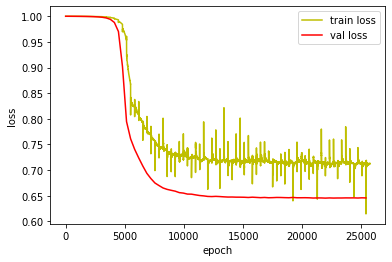

In [22]:
xx = np.linspace(0, len(history_drmm.history['loss']), len(history_drmm.history['loss'])//((len(train)//batch_size)+1), endpoint=False)
plt.plot(history_drmm.history['loss'], 'y', label='train loss')
plt.plot(xx, history_drmm.history['val_loss'], 'r', label='val loss')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

In [14]:
pacrr = Gen_PACRR_Model(firstk, lq, lg, nf, ns, bert=True)
pacrr.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=.1),
              loss=Pairwise_ranking_loss)

history_pacrr = LossHistory()
pacrr_metric = _metric(test)

total_epoch_count = 30
batch_size = 128
pacrr.fit(x=metadata, y=tf.constant([0.]*len(train)), 
          validation_data=(metadata_dev, tf.constant([0.]*len(dev))),
          shuffle=True,
          epochs=total_epoch_count,
          batch_size=batch_size,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                     history_pacrr,
                     pacrr_metric])

Epoch 1/30
685/685 [==============================] - 142s 207ms/step - loss: 0.8379 - val_loss: 0.6773
Epoch 2/30
685/685 [==============================] - 141s 206ms/step - loss: 0.7229 - val_loss: 0.6601
Epoch 3/30
685/685 [==============================] - 143s 209ms/step - loss: 0.6930 - val_loss: 0.6424
Epoch 4/30
685/685 [==============================] - 147s 215ms/step - loss: 0.6752 - val_loss: 0.6415
Epoch 5/30
685/685 [==============================] - 146s 213ms/step - loss: 0.6597 - val_loss: 0.6354
Epoch 6/30
685/685 [==============================] - 146s 213ms/step - loss: 0.6481 - val_loss: 0.6624
Epoch 7/30
685/685 [==============================] - 146s 213ms/step - loss: 0.6401 - val_loss: 0.6633
Epoch 8/30
685/685 [==============================] - 147s 215ms/step - loss: 0.6314 - val_loss: 0.6520
Epoch 9/30
685/685 [==============================] - 147s 214ms/step - loss: 0.6239 - val_loss: 0.6582
Epoch 10/30
685/685 [==============================] - 147s 214m

In [ ]:
history_plot(history_pacrr, pacrr_metric, batch_size, df=train)

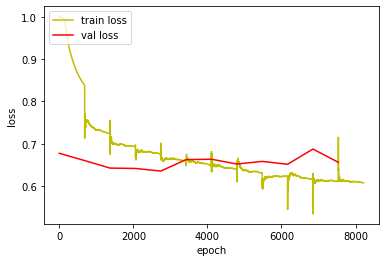

In [15]:
xx = np.linspace(0, len(history_pacrr.history['loss']), len(history_pacrr.history['loss'])//((len(train)//batch_size)+1), endpoint=False)
plt.plot(history_pacrr.history['loss'], 'y', label='train loss')
plt.plot(xx, history_pacrr.history['val_loss'], 'r', label='val loss')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(loc='upper left')
plt.show()

In [16]:
pacrr_drmm = Gen_PACRR_DRMM_Model(firstk, lq, lg, nf, ns, bert=True)

pacrr_drmm.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=.1),
                   loss=Pairwise_ranking_loss)

history_pacrr_drmm = LossHistory()
pacrr_drmm_metric = _metric(test)
total_epoch_count = 20
batch_size = 128
pacrr_drmm.fit(x=metadata, y=tf.constant([0.]*len(train)),
               validation_data=(metadata_dev, tf.constant([0.]*len(dev))),
               shuffle=True,
               epochs=total_epoch_count,
               batch_size=batch_size,
               callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                          history_pacrr_drmm,
                          pacrr_drmm_metric])

Epoch 1/20
685/685 [==============================] - 147s 215ms/step - loss: 0.7024 - val_loss: 0.6042
Epoch 2/20
685/685 [==============================] - 153s 223ms/step - loss: 0.6087 - val_loss: 0.6028
Epoch 3/20
685/685 [==============================] - 152s 221ms/step - loss: 0.5890 - val_loss: 0.6211
Epoch 4/20
685/685 [==============================] - 160s 233ms/step - loss: 0.5758 - val_loss: 0.6443
Epoch 5/20
685/685 [==============================] - 170s 248ms/step - loss: 0.5658 - val_loss: 0.6543
Epoch 6/20
685/685 [==============================] - 179s 261ms/step - loss: 0.5588 - val_loss: 0.6671
Epoch 7/20
685/685 [==============================] - 172s 251ms/step - loss: 0.5522 - val_loss: 0.6699
Epoch 8/20
685/685 [==============================] - 156s 227ms/step - loss: 0.5469 - val_loss: 0.6759
Epoch 9/20
685/685 [==============================] - 161s 235ms/step - loss: 0.5421 - val_loss: 0.6775


In [ ]:
history_plot(history_pacrr_drmm, pacrr_drmm_metric, batch_size, df=train)

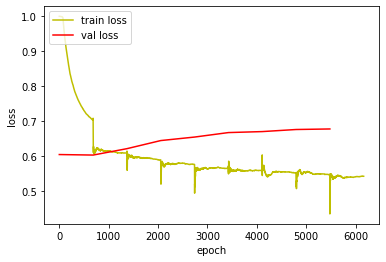

In [17]:
xx = np.linspace(0, len(history_pacrr_drmm.history['loss']), len(history_pacrr_drmm.history['loss'])//((len(train)//batch_size)+1), endpoint=False)

plt.plot(history_pacrr_drmm.history['loss'], 'y', label='train loss')
plt.plot(xx, history_pacrr_drmm.history['val_loss'], 'r', label='val loss')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(loc='upper left')
plt.show()

In [23]:
ndcg_test = test[test['query'] == random.sample(dev_q, 1)[0]]
metadata_ndcg = {'negative_sim_matrix' : tf.constant(ndcg_test['sim_matrix'].tolist(), dtype=tf.float32, name='negative_sim_matrix'),
                 'positive_sim_matrix' : tf.constant(ndcg_test['sim_matrix'].tolist(), dtype=tf.float32, name='positive_sim_matrix'),
                 'idf_softmax'         : tf.constant(ndcg_test['idf_softmax'].tolist(), dtype=tf.float32, name='idf_softmax'),
                 'query_idf'           : tf.ragged.constant(ndcg_test['query_idf'], dtype=tf.float32, ragged_rank=1, name='query_idf'),
                 'positive_hist'       : tf.ragged.constant(ndcg_test['drmm_hist'], dtype=tf.float32, ragged_rank=1, name='positive_hist'),
                 'negative_hist'       : tf.ragged.constant(ndcg_test['drmm_hist'], dtype=tf.float32, ragged_rank=1, name='negative_hist')}

ndcg_test.insert(5, 'rel_drmm', drmm.predict(metadata_ndcg)[:len(ndcg_test)], True)
ndcg_test.insert(5, 'rel_pacrr', pacrr.predict(metadata_ndcg)[:len(ndcg_test)], True)
ndcg_test.insert(5, 'rel_pacrr_drmm', pacrr_drmm.predict(metadata_ndcg)[:len(ndcg_test)], True)

pacrr_drmm_pred = ndcg_test.sort_values(by=['rel_pacrr_drmm'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel_pacrr_drmm', 'rel_pacrr', 'rel_drmm']]
pacrr_drmm_pred.style.apply(highlight, axis=1).set_properties(subset=['query', "product_title"], **{'text-align': 'left'}).hide_index()

query,product_title,median_relevance,rel_pacrr_drmm,rel_pacrr,rel_drmm
seagate 2tb hard disk,Seagate 2TB Laptop SATA Hard Disk Drive Kit,4,9.560463,0.996108,61.282822
seagate 2tb hard disk,New Seagate 2TB Desktop Internal Hard drive SATA 64MB CACHE STBD2000101,4,8.440396,0.997933,58.563442
seagate 2tb hard disk,SAMSUNG M9T Seagate 2TB 2000GB 2.5 SATA3 Notebook Hard Disk Drive Laptop PS3 PS4,4,8.178037,0.946728,52.858910
seagate 2tb hard disk,Seagate 2 TB External Hard Drive - USB 3.0 - Portable,4,8.033478,-0.522479,46.457767
seagate 2tb hard disk,2TB Samsung Seagate Momentus SpinPoint ST2000LM003 2 TB 2.5 SATA Notebook PS4,4,7.925866,0.551688,40.338440
seagate 2tb hard disk,"Seagate 2 TB 3.5 Internal Hard Drive - SAS - 7200 rpm - 128 MB Buffer - 1 Pack""",4,7.684924,0.234171,48.297108
seagate 2tb hard disk,Lot of 2 Seagate ST2000DM001 2TB SATA disks,4,7.653218,0.708915,52.368202
seagate 2tb hard disk,Seagate Technology ST2000DM001 HDD Barracuda 2TB SATAII 6Gb-s 7200rpm Cache Bare Drive,4,7.358487,-0.418689,37.689583
seagate 2tb hard disk,Seagate 1 TB Internal Hard Drive - SATA - 7200 rpm - 32 MB Buffer - Hot Swappable - Retail,2,7.330805,-0.867413,37.850964
seagate 2tb hard disk,2TB Seagate Backup Plus Slim Portable External Hard Drive USB 3.0 STDR2000101,4,7.237055,0.783336,56.506355


In [24]:
pacrr_pred = ndcg_test.sort_values(by=['rel_pacrr'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel_pacrr_drmm', 'rel_pacrr', 'rel_drmm']]
pacrr_pred.style.apply(highlight, axis=1).set_properties(subset=['query', "product_title"], **{'text-align': 'left'}).hide_index()

query,product_title,median_relevance,rel_pacrr_drmm,rel_pacrr,rel_drmm
seagate 2tb hard disk,New Seagate 2TB Desktop Internal Hard drive SATA 64MB CACHE STBD2000101,4,8.440396,0.997933,58.563442
seagate 2tb hard disk,Seagate 2TB Laptop SATA Hard Disk Drive Kit,4,9.560463,0.996108,61.282822
seagate 2tb hard disk,SAMSUNG M9T Seagate 2TB 2000GB 2.5 SATA3 Notebook Hard Disk Drive Laptop PS3 PS4,4,8.178037,0.946728,52.858910
seagate 2tb hard disk,2TB Seagate Backup Plus Slim Portable External Hard Drive USB 3.0 STDR2000101,4,7.237055,0.783336,56.506355
seagate 2tb hard disk,Lot of 2 Seagate ST2000DM001 2TB SATA disks,4,7.653218,0.708915,52.368202
seagate 2tb hard disk,2TB Samsung Seagate Momentus SpinPoint ST2000LM003 2 TB 2.5 SATA Notebook PS4,4,7.925866,0.551688,40.338440
seagate 2tb hard disk,"NEW Samsung Seagate Momentus ST2000LM003 2TB 2.5 SATA Notebook Hard Drive 32MB""",3,6.373684,0.307800,42.394238
seagate 2tb hard disk,"Seagate Expansion STBV2000100 2 TB 3.5 External Hard Drive""",4,6.965181,0.238503,38.962910
seagate 2tb hard disk,"Seagate 2 TB 3.5 Internal Hard Drive - SAS - 7200 rpm - 128 MB Buffer - 1 Pack""",4,7.684924,0.234171,48.297108
seagate 2tb hard disk,Seagate - Central 2TB Personal Cloud Storage,1,7.156185,0.049543,51.266811


In [25]:
drmm_pred = ndcg_test.sort_values(by=['rel_drmm'], axis=0, ascending=False)[['query', 'product_title', 'median_relevance', 'rel_pacrr_drmm', 'rel_pacrr', 'rel_drmm']]
drmm_pred.style.apply(highlight, axis=1).set_properties(subset=['query', "product_title"], **{'text-align': 'left'}).hide_index()

query,product_title,median_relevance,rel_pacrr_drmm,rel_pacrr,rel_drmm
seagate 2tb hard disk,Seagate 2TB Laptop SATA Hard Disk Drive Kit,4,9.560463,0.996108,61.282822
seagate 2tb hard disk,New Seagate 2TB Desktop Internal Hard drive SATA 64MB CACHE STBD2000101,4,8.440396,0.997933,58.563442
seagate 2tb hard disk,2TB Seagate Backup Plus Slim Portable External Hard Drive USB 3.0 STDR2000101,4,7.237055,0.783336,56.506355
seagate 2tb hard disk,SAMSUNG M9T Seagate 2TB 2000GB 2.5 SATA3 Notebook Hard Disk Drive Laptop PS3 PS4,4,8.178037,0.946728,52.858910
seagate 2tb hard disk,Lot of 2 Seagate ST2000DM001 2TB SATA disks,4,7.653218,0.708915,52.368202
seagate 2tb hard disk,Seagate - Central 2TB Personal Cloud Storage,1,7.156185,0.049543,51.266811
seagate 2tb hard disk,"Seagate 2 TB 3.5 Internal Hard Drive - SAS - 7200 rpm - 128 MB Buffer - 1 Pack""",4,7.684924,0.234171,48.297108
seagate 2tb hard disk,Seagate 2 TB External Hard Drive - USB 3.0 - Portable,4,8.033478,-0.522479,46.457767
seagate 2tb hard disk,"NEW Samsung Seagate Momentus ST2000LM003 2TB 2.5 SATA Notebook Hard Drive 32MB""",3,6.373684,0.307800,42.394238
seagate 2tb hard disk,"Seagate Expansion 2 TB,External,7200 RPM (ST320005EXA101-RK) Hard Drive",4,7.053564,-0.862551,41.523972
